# **Sprint 8.01** - Visualizaciones en Python

Esta práctica permitirá explorar cómo se pueden utilizar herramientas de visualización avanzadas en Python para interpretar y presentar datos de forma efectiva, proporcionando una oportunidad valiosa para mejorar las habilidades analíticas y técnicas.


## **Nivel 1**

#### Realiza la conexión en Python con MySQL Workbench para cargar toda la información que tienes en las tablas.


In [ ]:
# Para realizar la conección entre Python y MySQL, y también poder utilizar las herramientas de visualizacion, primero instalaremos los paquetes necesarios.
!pip install mysql-connector-python
!pip install pandas
!pip install matplotlib
!pip install seaborn

In [1]:
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### Obtención y procesamiento de tablas de MySQL como DataFrames en Python

Para cargar las tablas de una base de datos MySQL y manipularlas como DataFrames en Python, seguimos estos pasos:

1. Conectarse a MySQL: Se establece la conexión utilizando `mysql.connector`, proporcionando las credenciales necesarias (host, usuario, contraseña y base de datos).

2. Obtener los nombres de las tablas: Se ejecuta la consulta `SHOW TABLES` y se almacena el resultado en una lista.

3. Cargar los datos en DataFrames:Se recorre la lista de tablas y, para cada una, se ejecuta una consulta `SELECT * FROM <table>`. Los datos obtenidos se almacenan en un diccionario con nombres dinámicos (`DataFrames['df_<table>']`).

4. Actualizar el espacio de nombres local: Se usa `locals().update(DataFrames)` para que los DataFrames puedan accederse directamente por su nombre (ejemplo: `df_credit_card` en lugar de `DataFrames['df_credit_card']`).

5. Cerrar conexión y transformar datos: Se cierran el cursor y la conexión a MySQL. Luego, se convierten algunas columnas a tipos adecuados (`datetime`, `float`, `bool`).


In [ ]:
db_connection = mysql.connector.connect(
    host='localhost', 
    user='root', 
    password='root', 
    database='db_transactions')

cursor = db_connection.cursor()
cursor.execute("SHOW TABLES")
MySQL_tables = [table[0] for table in cursor.fetchall()]

DataFrames = {}
cursor = db_connection.cursor(dictionary=True)
for table in MySQL_tables:
    cursor.execute(f"SELECT * FROM {table}")
    DataFrames[f"df_{table}"] = pd.DataFrame(cursor.fetchall())

print(DataFrames.keys())
locals().update(DataFrames)

cursor.close()
db_connection.close()

# Con el método df.info() daremos un vistazo a los dataframes, para transformar las columnas que lo necesiten.
df_credit_card['expiring_date'] = pd.to_datetime(df_credit_card['expiring_date'])
df_product = df_product.astype({'price': float, 'weight': float})
df_transaction = df_transaction.astype({'amount': float, 'declined': bool})
df_user['birth_date'] = pd.to_datetime(df_user['birth_date'])

dict_keys(['df_company', 'df_credit_card', 'df_credit_card_state', 'df_product', 'df_transaction', 'df_transaction_products', 'df_user'])


#### Aquí agruparé los merge que serán necesarios luego en las gráficas.

In [88]:
# Ejercicio 2:
df_transaction['products_per_transaction'] = df_transaction['products_ids'].apply(lambda x: len(str(x).split(',')))

# Ejercicio 3:
df_company['companies_per_country'] = df_company.groupby('country')['id'].transform('count')
df_count_of_companies = df_company.sort_values(by='companies_per_country', ascending=False).reset_index(drop=True)

# Ejercicio 4:
df_company_transactions = pd.merge(df_company, df_transaction, left_on='id', right_on='company_id', how='outer')
df_sum_of_amount = df_company_transactions.groupby('country')['amount'].sum().reset_index().sort_values(by='amount', ascending=True)

# Ejercicio 5:
# df_company_transactions = pd.merge(df_company, df_transaction, left_on='id', right_on='company_id', how='outer')
df_company_transactions['transactions_per_country'] = df_company_transactions.groupby('country')['id_y'].transform('count')
df_count_of_transactions = df_company_transactions.sort_values(by='transactions_per_country', ascending=False).reset_index(drop=True)

# Ejercicio 6:
# df_company_transactions = pd.merge(df_company, df_transaction, left_on='id', right_on='company_id', how='outer')
df_country_summary = df_company_transactions.groupby('country').agg(average=('amount', 'mean'),total_amount=('amount', 'sum')).sort_values(by='average', ascending=False).reset_index()

# Ejercicio 7:
df_product_transaction_products = pd.merge(df_product, df_transaction_products, left_on='id', right_on='product_id', how='outer')
df_product_count = df_product_transaction_products.groupby(['id', 'price']).size().reset_index(name='times_sold')


#### Realizarás una visualización para cada ejercicio. Comenta lo que llama la atención de graficar esta variable, justifica la elección del gráfico e interpreta los resultados en función de tus datos.

### **Ejercicio 1:** Una variable numérica.

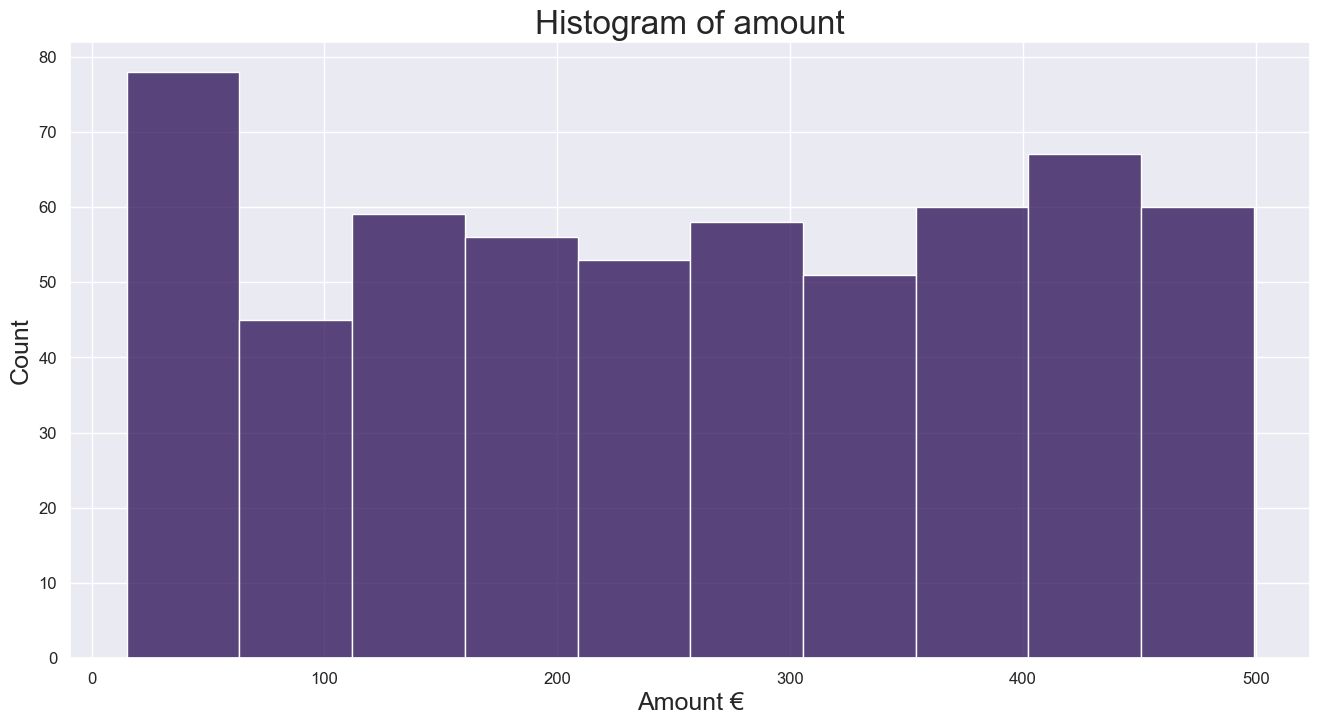

In [60]:
plt.figure(figsize=(16, 8))
sns.set_theme(style='darkgrid', palette='inferno')
ax = sns.histplot(df_transaction['amount'], bins=10)
plt.title('Histogram of amount', size=24)
plt.xlabel('Amount €',size=18)
plt.ylabel('Count', size=18)
plt.tick_params(axis='both', labelsize=12)
plt.show()

#### Análisis de la visualización:

Como podemos apreciar en el histograma, el mayor conteo de compras se dio en el tramo de 0 a 50 euros, con aproximadamente 78 transacciones registradas. El segundo tramo con mayor conteo es el de 400 a 450 euros, con alrededor de 66 transacciones. Los demás tramos presentan un conteo muy similar entre sí, oscilando entre 50 y 60 transacciones registradas.

Esto podría indicar que los usuarios suelen decidir sus compras basándose en factores distintos al precio total. Por ello, sería necesario profundizar en otros aspectos que permitan describir con mayor precisión los patrones de compra de nuestros usuarios. Analizar únicamente esta variable de forma aislada podría limitar el alcance del análisis. Al considerar más factores, obtendremos insights valiosos que nos permitirán trazar un plan de acción más efectivo.

### **Ejercicio 2:** Dos variables numéricas.

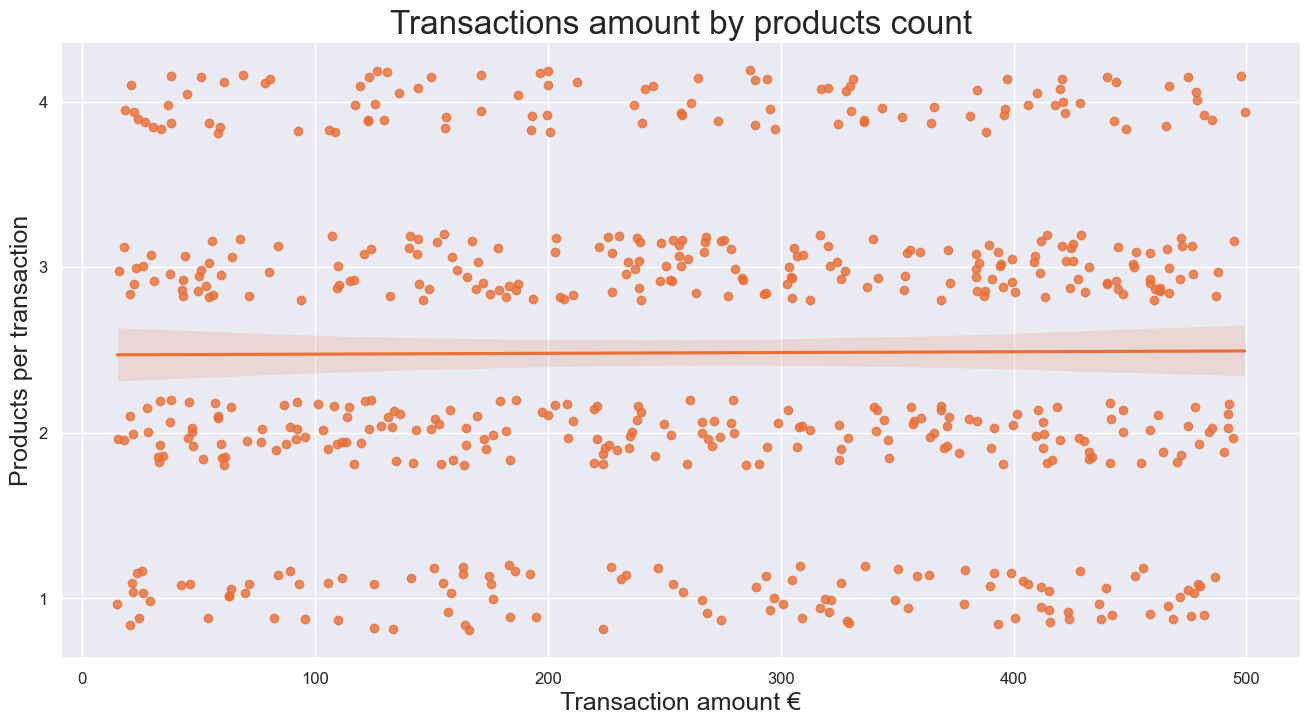

In [69]:
plt.figure(figsize=(16, 8))
sns.set_theme(style='darkgrid', palette='icefire_r')
ax = sns.regplot(data=df_transaction,
                 x='amount', y='products_per_transaction',
                 y_jitter=0.2)
plt.title('Transactions amount by products count', size=24)
plt.xlabel('Transaction amount €', size=18)
plt.ylabel('Products per transaction', size=18)
plt.yticks([1, 2, 3, 4])
plt.tick_params(axis='both', labelsize=12)
plt.show()

#### Análisis de la visualización:

La visualización muestra claramente que no existe una relación entre el monto total de las transacciones y la cantidad de productos en cada una. Este resultado es contraintuitivo, ya que esperaríamos que un mayor número de productos comprados se reflejara en un mayor monto por transacción.

Esto podría indicar posibles inconsistencias en la recolección de datos, lo que explicaría por qué algunas transacciones alcanzan casi 500 euros con un solo producto, mientras que otras con cuatro productos no superan los 50 euros. Para obtener análisis más precisos y útiles, sería recomendable revisar la calidad y precisión de los datos.

### **Ejercicio 3:** Una variable categórica.

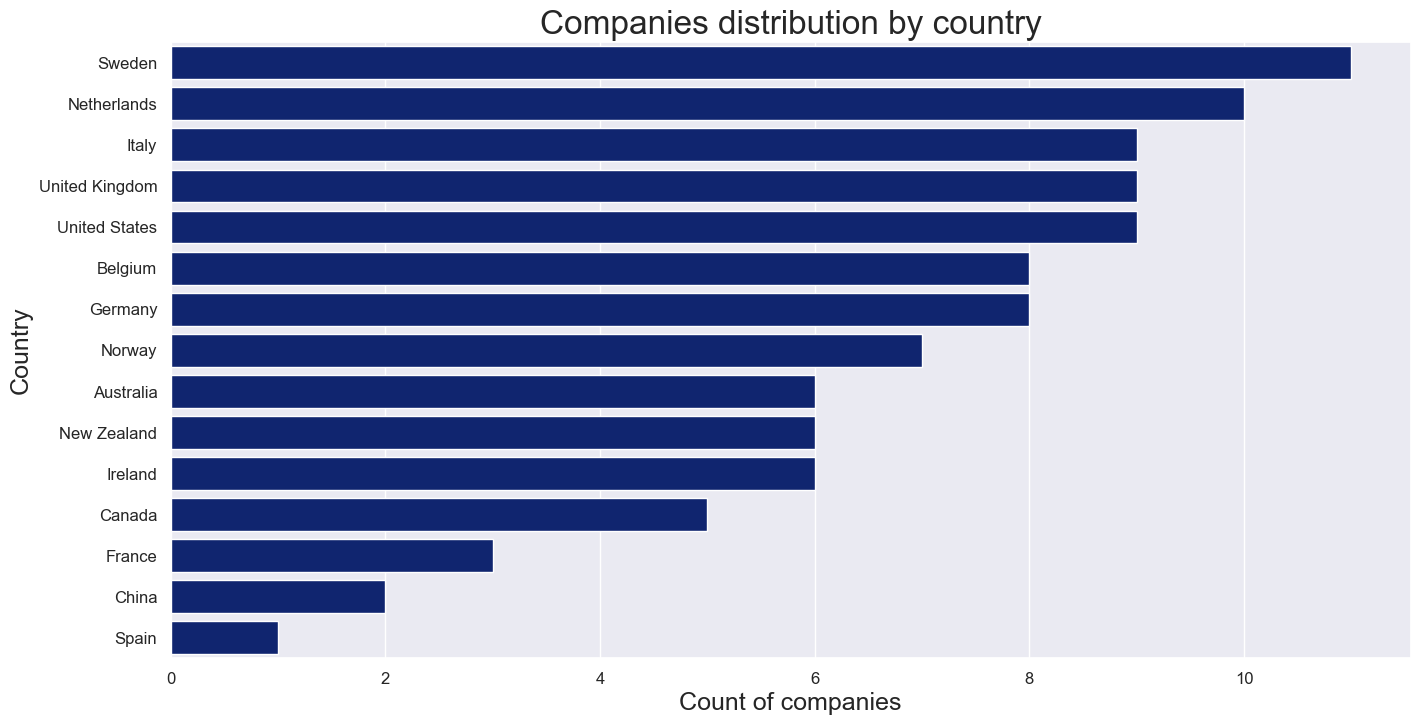

In [61]:
plt.figure(figsize=(16, 8))
sns.set_theme(style='darkgrid', palette='dark')
ax = sns.countplot(data=df_count_of_companies, y='country')
plt.title("Companies distribution by country", size=24)
plt.xlabel('Count of companies', size=18)
plt.ylabel('Country', size=18)
plt.tick_params(axis='both', labelsize=12)
plt.show()

#### Análisis de la visualización:

Apreciamos que el top 5 de países con mayor cantidad de compañías está compuesto por: Suecia, con 11 compañías; Holanda, con 10; y Reino Unido, Italia y Estados Unidos, con 9 compañías cada uno. Con esta información, esperaríamos que los países con más empresas fueran también los que generan mayores ingresos.

Dado que la gran mayoría de estos países se encuentran en Europa, podríamos desarrollar campañas de marketing personalizadas para esta región, con el objetivo de maximizar nuestros beneficios en este territorio.

### **Ejercicio 4:** Una variable categórica y una numérica.

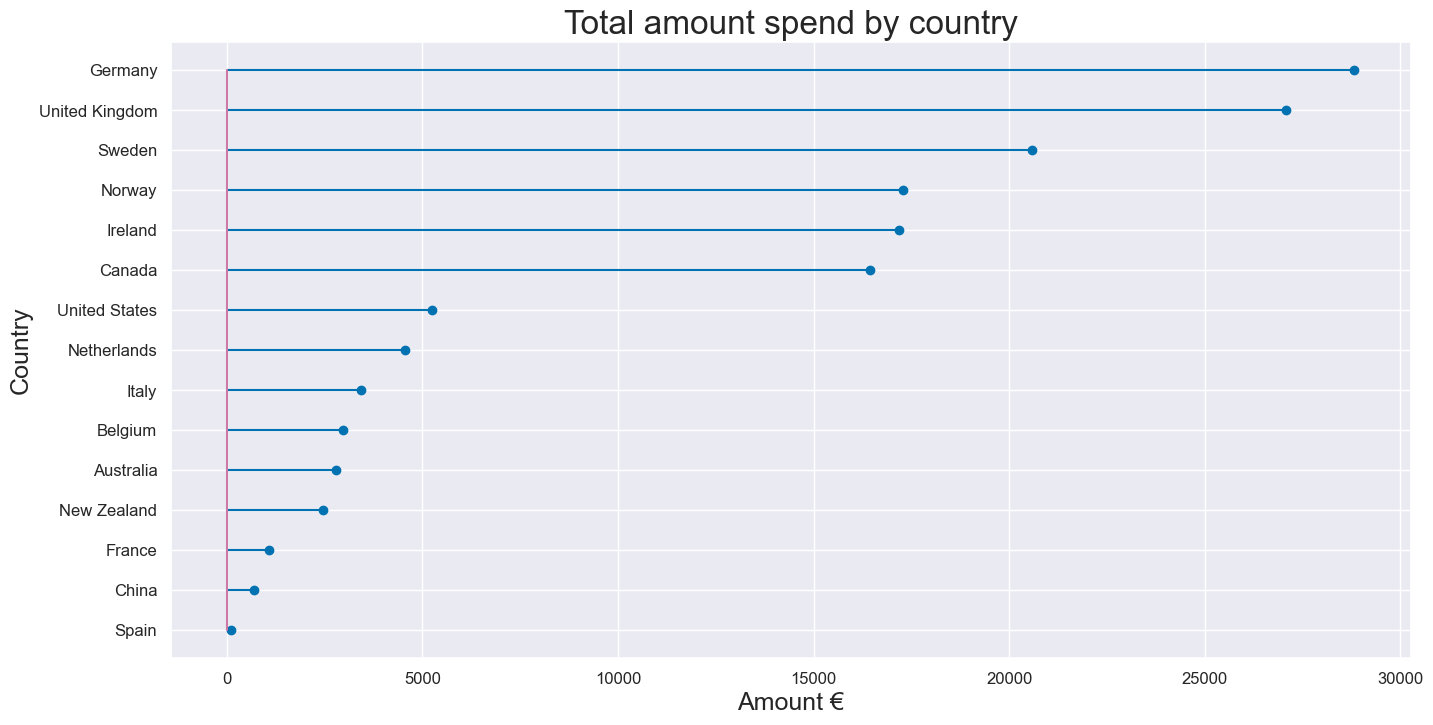

In [7]:
plt.figure(figsize=(16, 8))
plt.style.use('seaborn-v0_8-colorblind')
ax = plt.stem(df_sum_of_amount['country'], df_sum_of_amount['amount'], orientation='horizontal')
plt.title('Total amount spend by country', size=24)
plt.xlabel('Amount €', size=18)
plt.ylabel('Country', size=18)
plt.tick_params(axis='both', labelsize=12)
plt.show()

#### Análisis de la visualización:

Aquí podemos ver la sumatoria total de ventas por país. El top 5 está compuesto por Alemania, Reino Unido, Suecia, Noruega e Irlanda.

A primera vista, notamos que tanto Reino Unido como Suecia aparecen en este ranking, lo cual es esperable dado que cuentan con una gran cantidad de empresas en su territorio. Sin embargo, también destacan países como Alemania, Noruega e Irlanda, que, aunque no poseen tantas empresas, generan un alto beneficio con sus ventas.

Uno de los aspectos más llamativos es que países como Estados Unidos, Holanda e Italia, a pesar de estar en el top de naciones con más compañías, en conjunto apenas logran producir un poco más de la mitad de lo que Alemania genera por sí misma.

### **Ejercicio 5:** Dos variables categóricas.

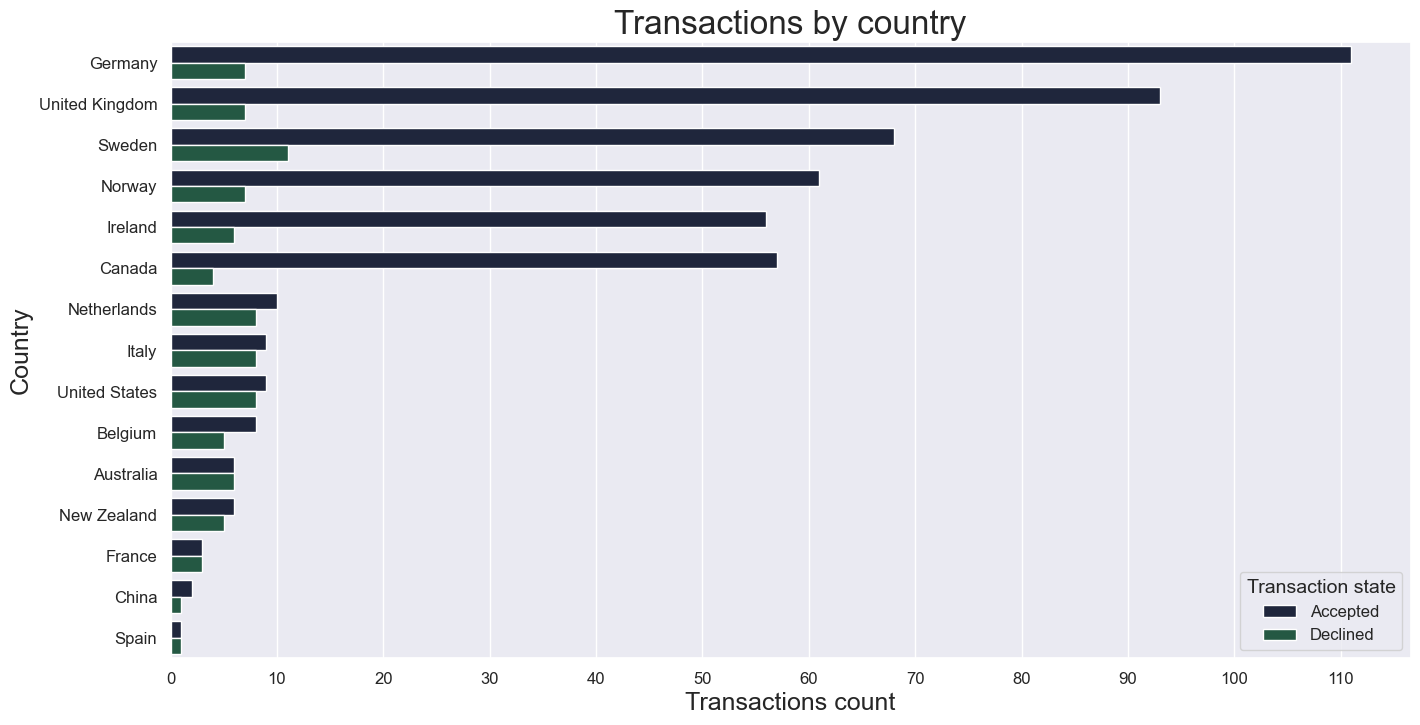

In [64]:
plt.figure(figsize=(16, 8))
sns.set_theme(style='darkgrid', palette='cubehelix')
ax = sns.countplot(data=df_count_of_transactions,
                   y='country', hue='declined')
ax.legend(title='Transaction state', labels=['Accepted', 'Declined'], fontsize=12, title_fontsize=14)
plt.title('Transactions by country', size=24)
plt.xlabel('Transactions count', size=18)
plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110])
plt.ylabel('Country', size=18)
plt.tick_params(axis='both', labelsize=12)
plt.show()

#### Análisis de la visualización:

Ahora observamos el conteo de transacciones por país, incluyendo tanto las aceptadas como las rechazadas.

El top 5 de países con más transacciones registradas está compuesto por Alemania, Reino Unido, Suecia, Noruega e Irlanda, coincidiendo exactamente con el ranking de mayores ventas que vimos anteriormente. Estos países se comportan como era de esperarse, con una gran cantidad de transacciones aceptadas y pocas rechazadas.

Sin embargo, también notamos una situación preocupante: Holanda, Italia y Estados Unidos no solo registran pocas transacciones aceptadas (menos de 10 cada uno), sino que además presentan un número de transacciones rechazadas prácticamente igual al de las aceptadas.

Por otro lado, Australia, Francia y España muestran una proporción equilibrada entre transacciones aceptadas y rechazadas.

En este punto, sería crucial analizar en mayor profundidad qué está causando un rendimiento tan bajo en estos países y evaluar si es un problema que podemos solucionar. De lo contrario, podríamos considerar si sería más rentable redirigir nuestros esfuerzos hacia los países que realmente están generando beneficios.

### **Ejercicio 6:** Tres variables.

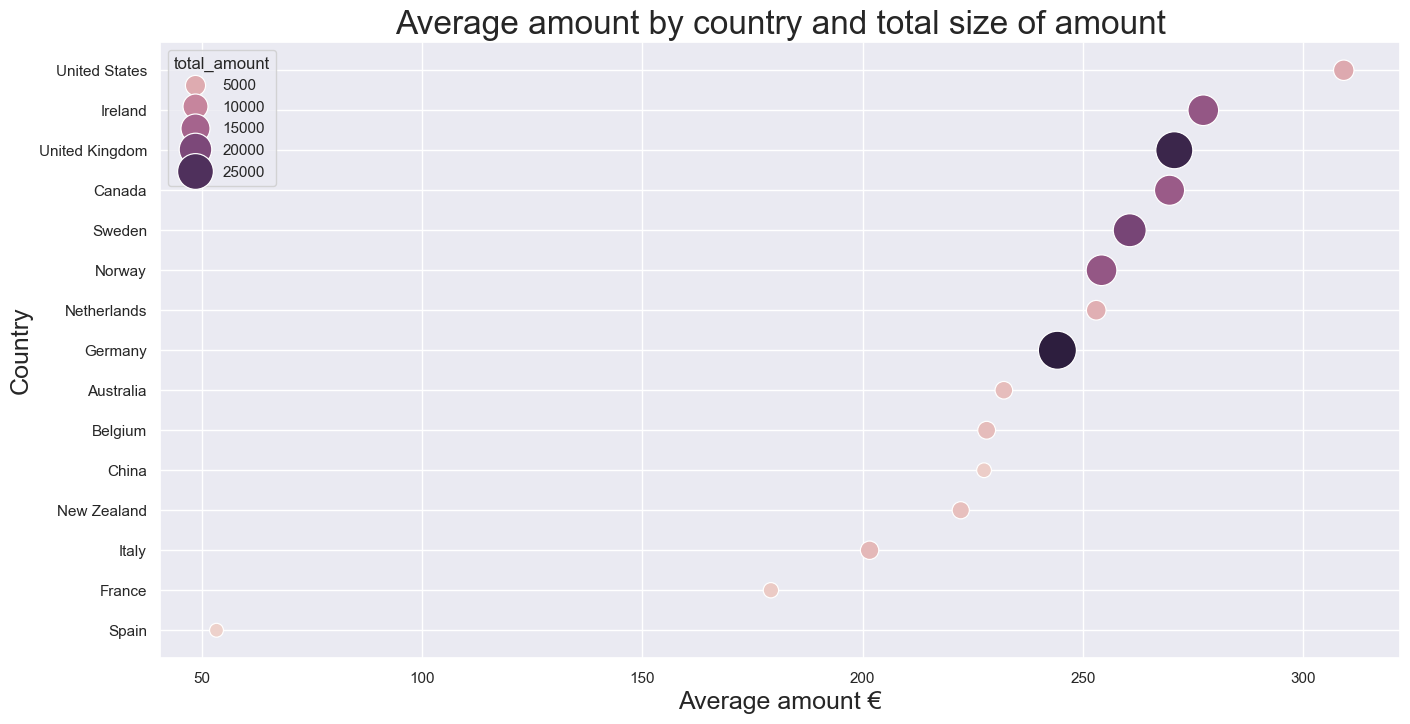

In [98]:
plt.figure(figsize=(16, 8))
sns.set_theme(style='darkgrid', palette='twilight_r')
ax = sns.scatterplot(data=df_country_summary, x='average', y='country', hue='total_amount', size='total_amount', sizes=(100,750))
plt.title('Average amount by country and total size of amount', size=24)
plt.xlabel('Average amount €', size=18)
plt.ylabel('Country', size=18)
plt.show()

#### Análisis de la visualización:

Aunque en el top 5 de países con mayores ventas totales se encuentran Irlanda, Reino Unido y Suecia—que también lideran en el promedio de ventas por transacción—la visualización no muestra una relación clara entre ambos indicadores. Sin embargo, sí se pueden identificar algunos patrones interesantes.

España se posiciona como el país con el menor total de ventas y, a su vez, con el menor promedio por transacción, lo que podría estar relacionado con un menor poder adquisitivo o hábitos de consumo distintos.

Alemania, a pesar de ser el país con el mayor volumen de ventas, tiene un promedio de venta intermedio, lo que sugiere un alto número de transacciones de montos moderados.

En contraste, EE.UU. presenta el promedio de venta más alto, pero su volumen total no es el mayor, lo que indica que, aunque sus transacciones individuales son de mayor valor, el número total de ventas es menor en comparación con otros países.

Estos patrones sugieren que distintos factores, como la cultura de consumo, los precios locales y las estrategias comerciales, pueden estar influyendo en la distribución de ventas en cada país.

### **Ejercicio 7:** Graficar un Pairplot.

<Figure size 1600x800 with 0 Axes>

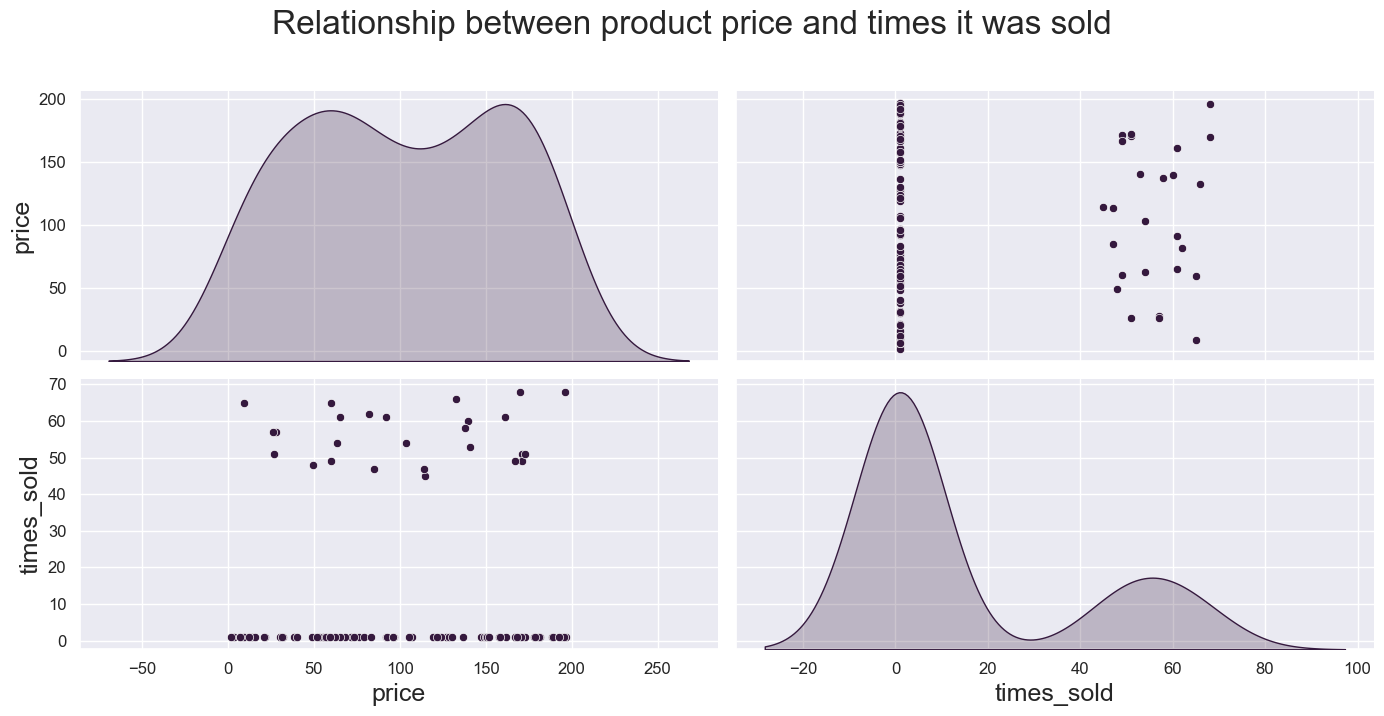

In [ ]:
plt.figure(figsize=(16, 8), layout="constrained")
sns.set_theme(style='darkgrid', palette='rocket')
ax = sns.pairplot(df_product_count, vars=['price', 'times_sold'], diag_kind='kde', height=3.5, aspect=2)
plt.suptitle('Relationship between product price and times it was sold', size=24, y=1.02)
for x in ax.axes.flatten():
    x.set_xlabel(x.get_xlabel(), fontsize=18)
    x.set_ylabel(x.get_ylabel(), fontsize=18)
    x.tick_params(axis='both', labelsize=12)
plt.tight_layout()
plt.show()

#### Análisis de la visualización:

Como podemos apreciar el PairPlot nos muestra dos grupos muy marcados:

1. Productos no vendidos: Son la gran mayoría y se concentran en cero ventas. Esto podría deberse a falta de demanda, precios poco atractivos o poca visibilidad.

2. Productos vendidos: Cada uno se vendió más de 40 veces, y lo interesante es que no hay una relación clara entre precio y cantidad de ventas. Esto sugiere que otros factores, como la marca, la calidad o el marketing, podrían ser más determinantes que el precio.

Dado que la mayoría de los productos no se vendieron ni una sola vez, sería clave analizar qué los hace diferentes de los que sí tuvieron éxito. Además, si el precio no es un factor decisivo en las ventas, quizá valga más la pena enfocarse en mejorar estrategias de promoción y posicionamiento en lugar de solo ajustar precios.